In [30]:
import os
os.environ["JAX_ENABLE_X64"] = "true"
import sys
sys.path.append('..')
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
from ipywidgets import interact
from ml_collections import ConfigDict
from models.ETD_KT_CM_JAX_Vectorised import *
from filters import resamplers
from filters.filter import ParticleFilter
from filters.filter import ParticleFilterAll
from jax import config
jax.config.update("jax_enable_x64", True)
import numpy as np

Initialisation of a twin experiment. 

In [31]:
signal_params = ConfigDict(KS_params_SALT)
ensemble_params = ConfigDict(KS_params_SALT)
ensemble_params.update(E=1,P=32,noise_magnitude = 0.01,stochastic_advection_basis='sin')
ensemble_params.update(E=128,P=32,noise_magnitude = 0.01,stochastic_advection_basis='sin')

Now we specify the models, by calling the class.

In [32]:
signal_model = ETD_KT_CM_JAX_Vectorised(signal_params)
ensemble_model = ETD_KT_CM_JAX_Vectorised(ensemble_params)

initial_signal = initial_condition(signal_model.x, signal_params.E, signal_params.initial_condition)
initial_ensemble = initial_condition(ensemble_model.x, ensemble_params.E, ensemble_params.initial_condition)

print(ensemble_model.params,ensemble_model.params.nt)
available_resamplers = ", ".join(resamplers.keys())
print(available_resamplers)

Advection_basis_name: sin
E: 128
Forcing_basis_name: none
P: 32
S: 0
c_0: 0
c_1: 1
c_2: 1
c_3: 0.0
c_4: 1
dt: 0.25
equation_name: Kuramoto-Sivashinsky
initial_condition: Kassam_Trefethen_KS_IC
method: Dealiased_SETDRK4
noise_magnitude: 0.01
nt: 600
nx: 256
stochastic_advection_basis: sin
tmax: 150
xmax: 100.53096491487338
xmin: 0
 600
multinomial, systematic, no_resampling, none, default


In [ ]:
observation_spatial_frequency = 32
observation_locations = np.arange(0,signal_model.x.shape[0],observation_spatial_frequency)
observation_noise = 0.1
number_of_observations_time = 32#32 #ensemble_model.params.nt
observation_temporal_frequency = int(ensemble_model.params.nt/number_of_observations_time)
print(f"Observation temporal frequency: {observation_temporal_frequency}")
print(f"Observation spatial locations:{observation_locations}")
pf_systematic = ParticleFilterAll(
    n_particles = ensemble_params.E,
    n_steps = observation_temporal_frequency,
    n_dim = initial_signal.shape[-1],
    forward_model = ensemble_model,
    signal_model = signal_model,
    sigma = observation_noise,
    resampling="systematic",#'default',
    observation_locations = observation_locations,
)

Observation temporal frequency: 18
Observation spatial locations:[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 23

To run the filter with all outputs, the input arrays need to have 3 dimensions.
They are (time, n_particles, space).

In [34]:
da_steps = number_of_observations_time
print(initial_ensemble.shape, initial_signal.shape, da_steps)
initial_ensemble = initial_ensemble[None, ...] # adding the time dimension
initial_signal = initial_signal[None, ...] # adding the time dimension
key = jax.random.PRNGKey(1) # random key for JAX
final, all = pf_systematic.run(initial_ensemble, initial_signal, da_steps,key) #the final input is scan length? 

(128, 256) (1, 256) 32


In [35]:
print("final shapes:")
for i, arr in enumerate(final):
    print(f"final[{i}]:", arr.shape)

print("\nall shapes:")
for i, arr in enumerate(all):
    print(f"all[{i}]:", arr.shape)

final shapes:
final[0]: (1, 128, 256)
final[1]: (1, 1, 256)
final[2]: (2,)

all shapes:
all[0]: (32, 18, 128, 256)
all[1]: (32, 18, 1, 256)
all[2]: (32, 1, 256)


The two outputs are tuples. The first tuple has length 2 and contains the final ensemble and the final signal arrays.
The second tuple has length three and contains all outputs through time of the ensemble, signal and observation.

Put in the initial condition.

In [36]:
# particles
print(initial_ensemble.shape)
print(all[0].shape)
all_0_reshaped = jnp.reshape(all[0], (-1, all[0].shape[2], all[0].shape[3]))
print(all_0_reshaped.shape)

particles =jnp.concatenate([initial_ensemble[...], all_0_reshaped], axis=0)
print(particles.shape)

## signal 
print(all[1].shape)
all_1_reshaped = jnp.reshape(all[1], (-1, all[1].shape[2], all[1].shape[3]))
print(all_1_reshaped.shape)
print(initial_signal.shape)
signal = jnp.concatenate([initial_signal[...], all_1_reshaped], axis=0)
print(signal.shape)

## observations
print(all[2].shape)
# observations = jnp.concatenate([initial_signal[...], all[2]], axis=0)
observations = all[2][:,:, observation_locations]
print(observations.shape)


(1, 128, 256)
(32, 18, 128, 256)
(576, 128, 256)
(577, 128, 256)
(32, 18, 1, 256)
(576, 1, 256)
(1, 1, 256)
(577, 1, 256)
(32, 1, 256)
(32, 1, 256)


In [37]:
def plot(time):
    plt.plot(signal_model.x, signal[time,0,:], color='k',label='signal')
    plt.plot(signal_model.x, particles[time,:,:].T, color='b',label='particles',linewidth=0.1)
    if (time ) % observation_temporal_frequency == 0 and time !=0:
        plt.plot(signal_model.x[observation_locations], observations[int(time/observation_temporal_frequency),0,:], 'ro',label='observations')
    plt.show()

interact(plot, time=(0, ensemble_model.params.nt - 1, 1))

interactive(children=(IntSlider(value=299, description='time', max=599), Output()), _dom_classes=('widget-inte…

<function __main__.plot(time)>

In [38]:
ensemble_params_none  = ConfigDict(KS_params_SALT)
ensemble_params_none.update(E=128,P=32,noise_magnitude = 0.01,stochastic_advection_basis='sin')
ensemble_model_none   = ETD_KT_CM_JAX_Vectorised(ensemble_params_none)
initial_signal_none   = initial_condition(signal_model.x, signal_params.E, signal_params.initial_condition)
initial_ensemble_none = initial_condition(ensemble_model.x, ensemble_params.E, ensemble_params.initial_condition)

pf_none = ParticleFilterAll(
    n_particles = ensemble_params.E,
    n_steps = observation_temporal_frequency,
    n_dim = initial_signal.shape[-1],
    forward_model = ensemble_model,
    signal_model = signal_model,
    sigma = observation_noise,
    resampling="no_resampling",#'default',
    observation_locations = observation_locations,
)
final_none, all_none = pf_none.run(initial_ensemble, initial_signal, da_steps,key) #the final input is scan length?
initial_ensemble_none = initial_ensemble_none[None, ...] # adding the time dimension
initial_signal_none = initial_signal_none[None, ...] # adding the time dimension
key = jax.random.PRNGKey(1) # random key for JAX

In [39]:
final_none, all_none = pf_none.run(initial_ensemble_none, initial_signal_none, da_steps,key)

In [40]:
all_none_0_reshaped = jnp.reshape(all_none[0], (-1, all_none[0].shape[2], all_none[0].shape[3]))
particles_none =jnp.concatenate([initial_ensemble_none[...], all_none_0_reshaped], axis=0)

print(all_none_0_reshaped.shape)

def plot_member_none(e):
    plt.imshow(particles_none[:, e, :], aspect='auto', origin='lower')
    plt.title(f'Ensemble member {e} (no resampling)')
    plt.xlabel('Space')
    plt.ylabel('Time')
    plt.show()

interact(plot_member_none, e=(0, all_none_0_reshaped.shape[1] - 1))

(576, 128, 256)


interactive(children=(IntSlider(value=63, description='e', max=127), Output()), _dom_classes=('widget-interact…

<function __main__.plot_member_none(e)>

In [41]:
def plot(time):
    plt.plot(signal_model.x, signal[time,0,:], color='k',label='signal')
    plt.plot(signal_model.x, particles[time,:,:].T, color='b',label='particles',linewidth=0.1)
    plt.plot(signal_model.x, particles_none[time,:,:].T, color='g',label='particles (no resampling)',linewidth=0.1)
    if (time ) % observation_temporal_frequency == 0 and time !=0:
        plt.plot(signal_model.x[observation_locations], observations[int(time/observation_temporal_frequency),0,:], 'ro',label='observations')
    plt.show()

interact(plot, time=(0, ensemble_model.params.nt - 1, 1))

interactive(children=(IntSlider(value=299, description='time', max=599), Output()), _dom_classes=('widget-inte…

<function __main__.plot(time)>

In [42]:
from metrics.ensemble import rmse, crps,crps_internal

# Compute RMSE and CRPS for the ensemble (with resampling)
rmse_ensemble = rmse(signal,particles)
crps_ensemble = crps_internal(signal, particles)#crps(signal,particles)

# Compute RMSE and CRPS for the ensemble (no resampling)
rmse_none = rmse(signal,particles_none)
crps_none = crps_internal(signal,particles_none)



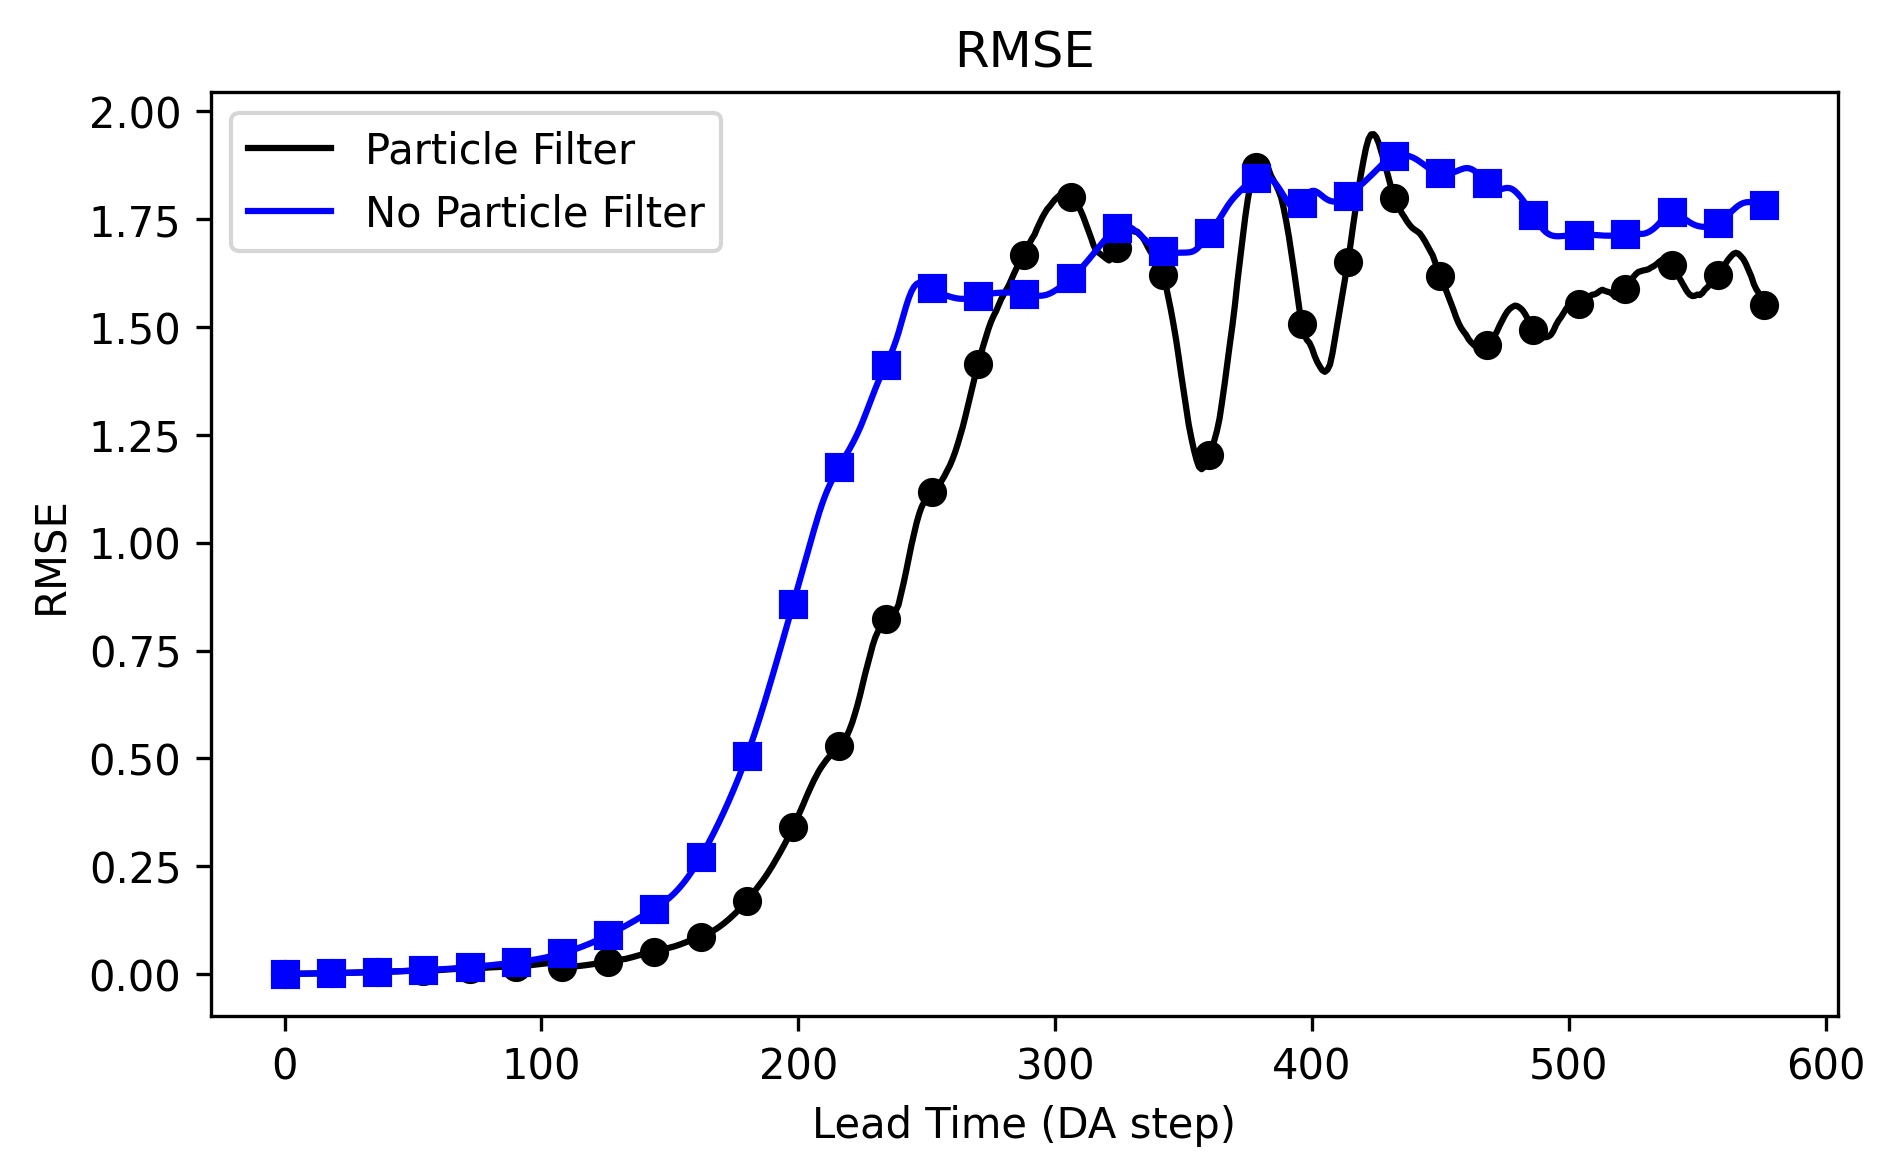

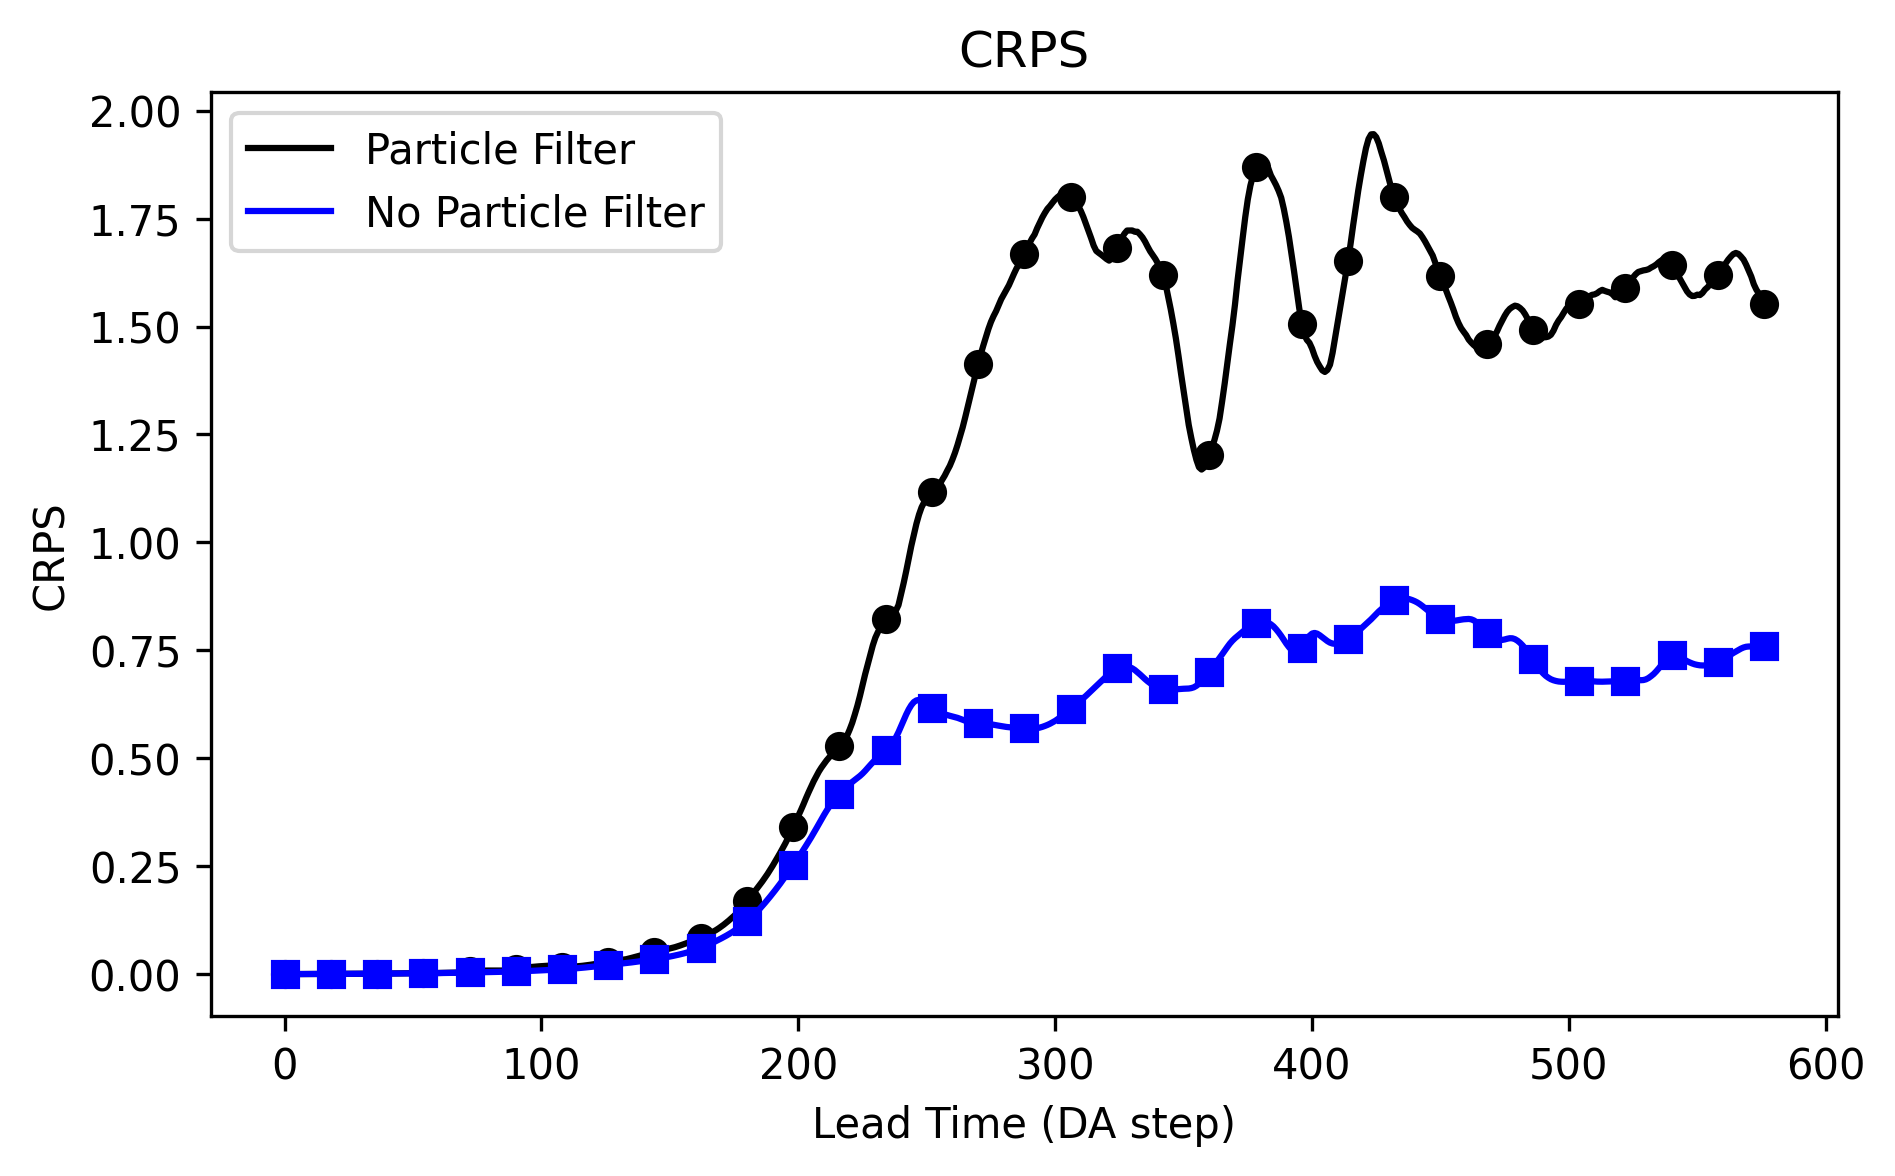

In [43]:
dpi=300
plt.figure(figsize=(7, 4), dpi=dpi)

# Plot RMSE with markers only at observation frequency
obs_idx = np.arange(0, len(rmse_ensemble), observation_temporal_frequency)
plt.plot(rmse_ensemble, color='black', marker='None', label='Particle Filter')
plt.plot(obs_idx, rmse_ensemble[obs_idx], color='black', marker='o', linestyle='None')

plt.plot(rmse_none, color='blue', marker='None', label='No Particle Filter')
plt.plot(obs_idx, rmse_none[obs_idx], color='blue', marker='s', linestyle='None')
# plt.plot(rmse_ensemble, color='black', marker='o', label='Particle Filter')
# plt.plot( rmse_none, color='blue', marker='s', label='No Particle Filter')
plt.xlabel('Lead Time (DA step)')
plt.ylabel('RMSE')
plt.title('RMSE')
plt.legend()
plt.savefig('/Users/jmw/Documents/GitHub/Particle_Filter/Saving/EX3a_KS_PF_NPF_RMSE.png', bbox_inches='tight', dpi=dpi)

plt.show()

# Plot CRPS with markers only at observation frequency
plt.figure(figsize=(7, 4), dpi=dpi)
plt.plot(crps_ensemble, color='black', marker='None', label='Particle Filter')
plt.plot(obs_idx, crps_ensemble[obs_idx], color='black', marker='o', linestyle='None')

plt.plot(crps_none, color='blue', marker='None', label='No Particle Filter')
plt.plot(obs_idx, crps_none[obs_idx], color='blue', marker='s', linestyle='None')

plt.xlabel('Lead Time (DA step)')
plt.ylabel('CRPS')
plt.title('CRPS')
plt.legend()
plt.savefig('/Users/jmw/Documents/GitHub/Particle_Filter/Saving/EX3a_KS_PF_NPF_CRPS.png', bbox_inches='tight', dpi=dpi)

plt.show()